# 1. Define function


**Reclassification Logic**

The `relclass` function reclassifies ESA CCI land cover classes into simplified categories:

| New Class | Description | Original ESA CCI Classes |
|-----------|-------------|--------------------------|
| 1 | Cropland | 10-40 |
| 2 | Forest | 50-90, 160, 170 |
| 3 | Savanna | 100, 110 |
| 4 | Shrub | 120, 121, 122 |
| 5 | Grassland and Arid Ecosystem | 130-153 |
| 6 | Wetland | 180 |
| 7 | Built-up | 190 |
| 8 | Bare Area and Ice | 200, 201, 202 |
| 9 | Water | 210 |


In [ ]:
import xarray as xr
import glob
import os
import numpy as np
from dask.diagnostics import ProgressBar

#220


def relclass(landcover_ds):
    # 创建一个新的Dataset
    reclassed = landcover_ds.copy()
    
    # 获取要处理的变量
    landcover_da = landcover_ds['lccs_class']

    #cropland
    cropland_mask = (landcover_da >= 10) & (landcover_da <= 40)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~cropland_mask, 1)
    
    #forest
    forest_mask = ((landcover_da >= 50) & (landcover_da <= 90)) \
                  | (landcover_da == 160) | (landcover_da == 170)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~forest_mask, 2)
    
    #savanna
    savanna_mask = (landcover_da == 100) | (landcover_da == 110)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~savanna_mask, 3)
    
    #shrub
    shrub_mask = (landcover_da == 120) | (landcover_da == 121) | (landcover_da == 122)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~shrub_mask, 4)
    
    #grassland and arid ecosystem
    grassland_mask = ((landcover_da >= 130) & (landcover_da <= 153))
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~grassland_mask, 5)
    
    #wetland
    wetland_mask = (landcover_da == 180)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~wetland_mask, 6)
    
    #built-up
    built_up_mask = (landcover_da == 190)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~built_up_mask, 7)
    
    #bare area and ice
    bare_area_mask = (landcover_da == 200) | (landcover_da == 201) | (landcover_da == 202) |(landcover_da == 220)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~bare_area_mask, 8)
    
    #water
    water_mask = (landcover_da == 210)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~water_mask, 9)

    return reclassed

# 定义统一的chunk大小
CHUNK_SIZE = 'auto'  # 使用文件原有的chunk大小

# 读取数据
lc = xr.open_dataset(
    'data/merged_lccs.nc',
    chunks=CHUNK_SIZE
)

# 重分类处理
reclassed_ds = relclass(lc)

# 设置输出路径
output_path = 'output/recalss_lccs.nc'

# 使用dask进行计算并保存
with ProgressBar():
    reclassed_ds.to_netcdf(
        output_path,
        engine="netcdf4",
        format="NETCDF4",
        encoding={"lccs_class": {"zlib": True, "complevel": 4}},
        compute=True
    )

print("Saved the reclassed result!")

## Create California place as example

In [2]:
import xarray as xr
import glob
import os
import numpy as np
from dask.diagnostics import ProgressBar
reclassed_ds= xr.open_dataset('output/merged_lccs.nc')
# Define California's approximate bounding box
ca_lat_min, ca_lat_max = 32.5, 42.0  # California's latitude range
ca_lon_min, ca_lon_max = -124.5, -114.0  # California's longitude range

# Slice the dataset to California's extent
ca_ds = reclassed_ds.sel(
    lat=slice(ca_lat_max, ca_lat_min),  # Note: slice goes from high to low for lat
    lon=slice(ca_lon_min, ca_lon_max)
)
bare_area_mask = (ca_ds["lccs_class"] == 220)
ca_ds['lccs_class'] = ca_ds['lccs_class'].where(~bare_area_mask, 8)
ca_ds.compute()
# Display the sliced dataset
ca_ds.where(ca_ds["lccs_class"] <= 9).to_netcdf("output/ca_lccs.nc")

# 2. Investigation (Study Area)

In [ ]:
import xarray as xr
import glob
import os
import numpy as np

ca_ds = xr.open_dataset("output/ca_lccs.nc")

# Create a dictionary mapping class values to descriptions
class_descriptions = {
    1: 'Cropland',
    2: 'Forest', 
    3: 'Savanna',
    4: 'Shrub',
    5: 'Grassland and Arid Ecosystem',
    6: 'Sparse vegetation',
    7: 'Urban/Built-up',
    8: 'Bareland',
    9: 'Water'
}

# Plot with custom colormap and legend
plot = ca_ds["lccs_class"].isel(time=0).plot(
    cmap='tab20',
    add_colorbar=True,
    cbar_kwargs={
        'label': 'Land Cover Classes',
        'ticks': list(class_descriptions.keys()),
        'format': lambda x, p: f'{int(x)}: {class_descriptions.get(int(x), "")}'
    }
)





# 3. Identify the cropland abandonment



Given : xarray dataset rc，
It has following properties:
    Dimensions: time: 31 lat: 3420  lon: 3780
    data variable (int)：lccs_class
    Where cropland is 1.
    

Let 非人工区域(non_artificial)为（not cropland (1) nor 7 (built-up)）

Create a new dataset Output: rc_new it has "abandonment_year", abandonment_duration


1. 检测所有满足下列条件的像素生成mask:
   1. 所有年里存在农田(1)
   2. non_artificial 的数量应>=5
   3. 至少存在第一个点是1，第二个点是non_artificial的情况


2. 根据这个mask， 遍历所有满足条件的像素tqdm(series)

For each point in series:
    duration=0
    year=None
    if the point is cropland:
        if duration >=5 and (not year):
            save result.
            下一个点
        else:
            year=对应的年份
            duration=0
    if the point is non_artificial and (year not None):
        duration=duration+1
        
    if是最后一个点并且 duration >=5,
        save result.


Save the result of year into a variable  "abandonment_year"
Save the result of duration into variable  "abandonment_duration"





In [18]:
rc = xr.open_dataset("output/ca_lccs.nc")

In [ ]:
rc

In [ ]:
import numpy as np
import xarray as xr
from tqdm import tqdm
# Create mask where:
# 1. Cropland exists in any year
# 2. Non-artificial areas >= 5 years
# 3. At least one sequence starts with cropland followed by non-artificial
cropland_exists = (rc.lccs_class == 1).any(dim='time')
non_artificial = ((rc.lccs_class != 1) & (rc.lccs_class != 7)).sum(dim='time') >= 5

# Check for cropland followed by non-artificial
has_sequence = False
for t in range(len(rc.time)-1):
    cropland_t = rc.lccs_class.isel(time=t) == 1
    non_artificial_t1 = (rc.lccs_class.isel(time=t+1) != 1) & (rc.lccs_class.isel(time=t+1) != 7)
    has_sequence = has_sequence | (cropland_t & non_artificial_t1)

mask = cropland_exists & non_artificial & has_sequence


# Create output arrays initialized with NaN
abandonment_year = np.full(rc.lccs_class.shape[1:], np.nan)
abandonment_duration = np.full(rc.lccs_class.shape[1:], np.nan)

# Get indices of masked pixels
lat_idx, lon_idx = np.where(mask)

# Iterate through masked pixels
for i, j in tqdm(zip(lat_idx, lon_idx), total=len(lat_idx)):
    duration = 0
    year = None
    series = rc.lccs_class.isel(lat=i, lon=j)
    for t, val in enumerate(series):
        if val == 1 :  # Cropland 
            if duration >= 5 and year is None:  # Save previous abandonment if duration met and no abandonment started
                abandonment_year[i,j] = year
                abandonment_duration[i,j] = duration
                break
            else:
                year = rc.time[t].values
                duration = 0
        elif ((val != 1) and (val != 7)) and year is not None:  # Non-artificial after cropland
            duration += 1
        else:  # Reset if we see cropland again before 5 years
            year = None
            duration = 0
        # Check last point
        if t == len(series)-1 and duration >= 5:
            abandonment_year[i,j] = year
            abandonment_duration[i,j] = duration

# Create new dataset with results
rc_new = xr.Dataset(
    data_vars={
        'abandonment_year': (['lat', 'lon'], abandonment_year),
        'abandonment_duration': (['lat', 'lon'], abandonment_duration)
    },
    coords={
        'lat': rc.lat,
        'lon': rc.lon
    }
)


In [ ]:
print(f"Number of non-NaN points: {np.count_nonzero(~np.isnan(rc_new['abandonment_duration']))}")
rc_new["abandonment_duration"].plot()


# Find first non-NaN point coordinates
valid_idx = np.where(~np.isnan(rc_new['abandonment_duration']))
example_i, example_j = valid_idx[0][0], valid_idx[1][0]

rc_new.isel(lat=example_i, lon=example_j)
rc["lccs_class"].isel(lat=example_i, lon=example_j).values


In [ ]:
rc_new["abandonment_year"].isel(lat=example_i, lon=example_j)

In [ ]:
# Create 5 bins for years between 1992-2022
rc_new["abandonment_year"].astype('datetime64[ns]').dt.year.sel(lon=slice(-120,-118.75), lat=slice(38,36)).plot(
    cmap='viridis',
    levels=[1992, 1998, 2004, 2010, 2016, 2022]  # Split into 5 intervals
)



In [ ]:
rc["lccs_class"].isel(time=1).sel(lon=slice(-120,-118.75), lat=slice(38,36)).where(rc["lccs_class"].isel(time=1) == 1).plot()

In [33]:
import xarray as xr
import numpy as np

# Suppose ds_ca is your Dataset with dims (time: 31, lat: 3420, long: 3780).
# lccs_class has integer-coded land-cover classes, where:
#   1 = cropland
#   7 = built-up
# (non_artificial means neither cropland nor built-up)

ds_ca=xr.open_dataset('output\ca_lccs.nc')
ds_ca
is_cropland = (ds_ca.lccs_class == 1)
is_builtup  = (ds_ca.lccs_class == 7)
is_non_artificial = ~(is_cropland | is_builtup) 

# C2:Count how many years each pixel is non-artificial; require >= 5
cond1 = (is_non_artificial.sum(dim='time') >= 5)
# C2:Check if at least one time-slice is cropland
cond2 = is_cropland.any(dim='time')


# C3: Check for any sequence where cropland is followed by 2 years of non-artificial land
cond3 = False
for t in range(len(ds_ca.time) - 2):
    cond3 = cond3 | (
        is_cropland.isel(time=t) 
        & is_non_artificial.isel(time=t+1) 
        & is_non_artificial.isel(time=t+2)
    )

# Fix the TypeError by ensuring all operands are boolean arrays
# Convert DataArrays to boolean type explicitly before performing bitwise operations
nonart_0 = is_non_artificial.astype(bool)
nonart_1 = is_non_artificial.shift(time=-1).fillna(False).astype(bool)
nonart_2 = is_non_artificial.shift(time=-2).fillna(False).astype(bool)
nonart_3 = is_non_artificial.shift(time=-3).fillna(False).astype(bool)
nonart_4 = is_non_artificial.shift(time=-4).fillna(False).astype(bool)

cond4 = (nonart_0 & nonart_1 & nonart_2 & nonart_3 & nonart_4).any(dim="time")

final_mask = cond1 & cond2 & cond3 & cond4





In [ ]:
# Plot the final mask where it's True
import matplotlib.pyplot as plt
final_mask.where(final_mask).plot(cmap='viridis')
plt.title('Areas meeting all abandonment criteria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [ ]:
# Implement the abandonment calculation algorithm
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
# Create arrays to store results
abandonment_year = np.full_like(ds_ca['lccs_class'].isel(time=0).values, np.nan, dtype=float)
abandonment_duration = np.full_like(ds_ca['lccs_class'].isel(time=0).values, np.nan, dtype=float)
recultivation = np.zeros_like(ds_ca['lccs_class'].isel(time=0).values, dtype=bool)
current_abandonment = np.zeros_like(ds_ca['lccs_class'].isel(time=0).values, dtype=bool)

# Get time values as years
years = ds_ca.time.dt.year.values

# Get indices of valid pixels using where
valid_indices = np.where(final_mask.values)



for i in tqdm(range(len(valid_indices[0])), desc="Processing pixels"):
    y, x = valid_indices[0][i], valid_indices[1][i]
    
    duration = 0
    abandonment_start = None
    
    # Process the time series for this pixel
    for t in range(len(years)):
        is_crop = is_cropland.isel(time=t).values[y, x]
        is_nonart = is_non_artificial.isel(time=t).values[y, x]
        
        if is_crop:
            # If previously abandoned for 5+ years, mark as recultivated
            if abandonment_start is not None and duration >= 5:
                recultivation[y, x] = True
                abandonment_year[y, x] = abandonment_start
                abandonment_duration[y, x] = duration
            # Reset tracking for cropland
            abandonment_start = None
            duration = 0
        elif is_nonart:
            # Start tracking abandonment if not already and previous year was cropland
            if abandonment_start is None and t > 0 and is_cropland.isel(time=t-1).values[y, x]:
                abandonment_start = years[t]
            
            # Increment duration if we're tracking abandonment
            if abandonment_start is not None:
                duration += 1
        else:
            # Reset if artificial land
            abandonment_start = None
            duration = 0
    
    # After processing all years, check if currently abandoned (2022)
    if abandonment_start is not None and duration >= 5:
        current_abandonment[y, x] = True
        abandonment_year[y, x] = abandonment_start
        abandonment_duration[y, x] = duration

# Convert results to DataArrays with the same coordinates as the input
abandonment_year_da = xr.DataArray(
    abandonment_year,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='abandonment_year'
)

recultivation_da = xr.DataArray(
    recultivation,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='recultivation'
)

current_abandonment_da = xr.DataArray(
    current_abandonment,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='current_abandonment'
)

abandonment_duration_da = xr.DataArray(
    abandonment_duration,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='Abandonment_Duration'
)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
abandonment_year_da.where(~np.isnan(abandonment_year_da)).plot(cmap='viridis')
plt.title('Year of Abandonment')

plt.subplot(2, 2, 2)
current_abandonment_da.where(current_abandonment_da).plot(cmap='Reds')
plt.title('Currently Abandoned Land')

plt.subplot(2, 2, 3)
recultivation_da.where(recultivation_da).plot(cmap='Greens')
plt.title('Recultivated Land')

plt.subplot(2, 2, 4)
abandonment_duration_da.where(abandonment_duration_da > 0).plot(cmap='plasma')
plt.title('Abandonment Duration (Years)')

plt.tight_layout()

# Create new dataset with results




In [ ]:
# Create a new dataset with all the results
results_ca = xr.Dataset(
    data_vars={
        'current_abandonment': current_abandonment_da,
        'recultivation': recultivation_da,
        'abandonment_year': abandonment_year_da,
        'Abandonment_Duration':abandonment_duration_da
    }
)

# Export the dataset to a NetCDF file
output_file = 'output\california_cropland_abandonment_results.nc'
results_ca.to_netcdf(output_file)
print(f"Results exported to {output_file}")

# Display the dataset
results_ca

In [40]:
import xarray as xr
import rasterio
import glob
import os
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm
import numpy as np


### CA栅格统一

In [42]:
# Get all .tif files in the processed_tifs folder
processed_tifs_folder = 'processed_tifs'
tif_files = glob.glob(os.path.join(processed_tifs_folder, '*.tif'))

print(f"Found {len(tif_files)} .tif files in {processed_tifs_folder} folder")

# Function to get resolution of a GeoTIFF file
def get_tif_resolution(tif_path):
    with rasterio.open(tif_path) as src:
        # Get the transform
        transform = src.transform
        # Resolution is in the transform: (x_res, 0, x_min, 0, y_res, y_min, 0, 0, 1)
        x_res = abs(transform[0])  # Longitude resolution (x)
        y_res = abs(transform[4])  # Latitude resolution (y)
        
        # Convert to kilometers for better readability (assuming degrees)
        # Approximate conversion: 1 degree ≈ 111 km at the equator
        x_res_km = x_res * 111
        y_res_km = y_res * 111
        
        return {
            'file': os.path.basename(tif_path),
            'x_resolution_deg': x_res,
            'y_resolution_deg': y_res,
            'x_resolution_km': x_res_km,
            'y_resolution_km': y_res_km,
            'shape': src.shape,
            'crs': src.crs.to_string()
        }

# Get resolution for all files
print("Resolutions of all files in processed_tifs folder:")
print("-" * 100)
print(f"{'Filename':<40} {'X Res (deg)':<12} {'Y Res (deg)':<12} {'X Res (km)':<12} {'Y Res (km)':<12} {'Shape':<20} {'CRS'}")
print("-" * 100)

for tif_file in tif_files:
    res_info = get_tif_resolution(tif_file)
    print(f"{res_info['file']:<40} {res_info['x_resolution_deg']:<12.6f} {res_info['y_resolution_deg']:<12.6f} "
          f"{res_info['x_resolution_km']:<12.2f} {res_info['y_resolution_km']:<12.2f} {str(res_info['shape']):<20} {res_info['crs']}")


Found 18 .tif files in processed_tifs folder
Resolutions of all files in processed_tifs folder:
----------------------------------------------------------------------------------------------------
Filename                                 X Res (deg)  Y Res (deg)  X Res (km)   Y Res (km)   Shape                CRS
----------------------------------------------------------------------------------------------------
ca_ horizontal_radiation.tif             0.002777     0.002777     0.31         0.31         (3420, 3780)         EPSG:4326
ca_Cloud_index_MODCF_meanannual.tif      0.002777     0.002777     0.31         0.31         (3420, 3780)         EPSG:4326
ca_DIF.tif                               0.002777     0.002777     0.31         0.31         (3420, 3780)         EPSG:4326
ca_distance_to_power.tif                 0.002777     0.002777     0.31         0.31         (3421, 3780)         EPSG:4326
ca_distance_to_settlements.tif           0.002777     0.002777     0.31         0.31    

In [ ]:
# Clip all the .tif data to California extent

ca_abandon=xr.open_dataset('output\california_cropland_abandonment_results.nc')
ca_abandon
# Get the extent and resolution from ca_abandon
ca_extent = {
    'left': float(ca_abandon.lon.min()),
    'right': float(ca_abandon.lon.max()),
    'bottom': float(ca_abandon.lat.min()),
    'top': float(ca_abandon.lat.max())
}

lon_res = float(np.diff(ca_abandon.lon)[0])  # Calculate longitude resolution
lat_res = float(np.diff(ca_abandon.lat)[0])  # Calculate latitude resolution
print(f"Longitude resolution: {lon_res}")
print(f"Latitude resolution: {lat_res}")

width = int(np.ceil((ca_extent['right'] - ca_extent['left']) / abs(lon_res)))
height = int(np.ceil((ca_extent['top'] - ca_extent['bottom']) / abs(lat_res)))

def process_tif(input_path, output_path, template_extent, width, height):
     # Choose resampling method based on file type
    if "urban_rural" in input_path.lower():
        resampling_method = Resampling.nearest
    else:
        resampling_method = Resampling.bilinear   
    
    # This can be modified according to the template data
    with rasterio.open(input_path) as src:
        print(f"\nProcessing file: {input_path}")
        print(f"Source CRS: {src.crs}")
        print(f"Source bounds: {src.bounds}")
        print(f"Source shape: {src.shape}")
        
        # Calculate the transform
        dst_transform = rasterio.transform.from_bounds(
            template_extent['left'],
            template_extent['bottom'],
            template_extent['right'],
            template_extent['top'],
            width,
            height
        )

        # Create output dataset
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({
            'crs': 'EPSG:4326',
            'transform': dst_transform,
            'width': width,
            'height': height,
            'nodata': src.nodata if src.nodata is not None else -9999
        })

        with rasterio.open(output_path, 'w', **dst_kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs='EPSG:4326',
                resampling=resampling_method,
                nodata=src.nodata if src.nodata is not None else -9999
            )

output_dir = 'processed_tifs'
os.makedirs(output_dir, exist_ok=True)

# # Delete all existing files in the output directory
# for file in os.listdir(output_dir):
#     file_path = os.path.join(output_dir, file)
#     if os.path.isfile(file_path):
#         os.remove(file_path)

# Process all TIF files
input_dir = r'D:\Photovoltaic_data'
tif_files = glob.glob(os.path.join(input_dir, '*.tif'))


for tif_file in tqdm(tif_files, desc="Processing TIF files", unit="file"):
    # Get the base filename and replace 'Global' with 'ca'
    base_filename = os.path.basename(tif_file)
    if 'Global' in base_filename:
        new_filename = base_filename.replace('Global', 'ca')
    else:
        new_filename = 'ca_' + base_filename
    
    output_file = os.path.join(output_dir, new_filename)
    
    try:
        process_tif(
            tif_file, 
            output_file, 
            ca_extent, 
            width,
            height
        )
        tqdm.write(f"Successfully processed {tif_file} to {new_filename}")
    except Exception as e:
        tqdm.write(f"Error processing {tif_file}: {str(e)}")




In [ ]:
# Plot all processed TIF files
import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np
from rasterio.plot import show
from matplotlib.colors import ListedColormap
from rasterio.enums import Resampling

output_dir = 'processed_tifs'
# Get all TIF files in the processed directory
processed_tifs = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.tif')]

# Create a figure with subplots based on the number of TIF files
n_files = len(processed_tifs)
n_cols = 2  # Number of columns in the subplot grid
n_rows = (n_files + n_cols - 1) // n_cols  # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_files > 1 else [axes]  # Ensure axes is always a list

# Process and plot each TIF file
for i, tif_file in enumerate(processed_tifs):
    if i < len(axes):  # Make sure we don't exceed the number of subplots
        with rasterio.open(tif_file) as src:
            # Downsample for visualization
            scale_factor = 10
            height = src.height // scale_factor
            width = src.width // scale_factor
            
            # Read the data at a lower resolution
            data = src.read(
                1,
                out_shape=(height, width),
                resampling=Resampling.bilinear  # Use bilinear for continuous data
            )
            
            # Create a masked array where nodata values are masked
            nodata_value = src.nodata if src.nodata is not None else -9999
            masked_data = np.ma.masked_where(data == nodata_value, data)
            
            # Plot the data using imshow with a mask for nodata values
            im = axes[i].imshow(masked_data, cmap='viridis')
            axes[i].set_title(os.path.basename(tif_file))
            
            # Add colorbar
            plt.colorbar(im, ax=axes[i], shrink=0.6)
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import rasterio
import os
import numpy as np
from rasterio.plot import show

output_path='output\Data_prepro'
# Use railway.tif as a baseline to create a validate data mask
base_input='processed_tifs\ca_railway.tif'
# Open the railway.tif file using rasterio instead of xarray
# Open the railway.tif file using rasterio
with rasterio.open(base_input) as src:
    # Read the data
    data = src.read(1)
    # Get metadata
    transform = src.transform
    crs = src.crs
    nodata = src.nodata
    
    # Create an xarray Dataset from the rasterio data
    # First, calculate x and y coordinates based on the transform
    height, width = data.shape
    x_coords = np.arange(width) * transform.a + transform.c
    y_coords = np.arange(height) * transform.e + transform.f
    
    # Create the xarray DataArray
    railway_xr = xr.DataArray(
        data=data,
        dims=["y", "x"],
        coords={
            "y": y_coords,
            "x": x_coords
        },
        attrs={
            "crs": str(crs),
            "nodata": nodata,
            "transform": transform
        }
    )
    
    # Convert to Dataset
    railway_ds = railway_xr.to_dataset(name="railway")
    
    # Display basic information
    print(f"Railway dataset loaded with shape: {railway_ds.railway.shape}")
    
    # Plot the data to visualize
    plt.figure(figsize=(10, 8))
    railway_ds.railway.plot()
    plt.title("Railway Data")
    plt.show()



Railway dataset resolution: 0.0027770429159375 degrees (x), 0.0027769655620559774 degrees (y)


<xarray.Dataset> Size: 103MB
Dimensions:  (y: 3420, x: 3780)
Coordinates:
  * y        (y) float64 27kB 42.0 42.0 41.99 41.99 ... 32.51 32.51 32.51 32.5
  * x        (x) float64 30kB -124.5 -124.5 -124.5 ... -114.0 -114.0 -114.0
Data variables:
    railway  (y, x) float64 103MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

### 创建标准化栅格


In [ ]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

def create_template_from_valid_pixels(reference_data, target_resolution, output_path=r'processed_tifs\template_valid.tif'):
    """
    Create a template keeping only areas with valid data in reference raster,
    using the resolution from a target raster
    """
    # Open the reference raster to get valid pixels
    with rasterio.open(reference_data) as src:
        # Read data and get valid pixels
        data = src.read(1)
        valid_mask = data != src.nodata
        ref_bounds = src.bounds
        ref_crs = src.crs
    
    # Open the target raster to get the resolution
    with rasterio.open(target_resolution) as target_src:
        # Get target resolution from the target raster
        target_transform = target_src.transform
        target_res_x = target_transform.a
        target_res_y = abs(target_transform.e)
        
        # Calculate new dimensions based on target resolution
        new_width = int((ref_bounds.right - ref_bounds.left) / target_res_x)
        new_height = int((ref_bounds.top - ref_bounds.bottom) / target_res_y)
        
        # Create new transform
        new_transform = from_origin(
            ref_bounds.left,
            ref_bounds.top,
            target_res_x,
            target_res_y
        )
    
    # Create template array with valid pixels only
    template = np.zeros((new_height, new_width), dtype=np.float32)
    
    # Resample valid mask to target resolution
    # Note: This is a simplified approach - for production use, consider using rasterio.warp
    from rasterio.warp import reproject, Resampling
    reproject(
        source=np.ones_like(data, dtype=np.float32) * valid_mask,
        destination=template,
        src_transform=src.transform,
        src_crs=ref_crs,
        dst_transform=new_transform,
        dst_crs=ref_crs,
        resampling=Resampling.nearest
    )
    
    # Write to file
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=new_height,
        width=new_width,
        count=1,
        dtype=np.float32,
        crs=ref_crs,
        transform=new_transform,
        nodata=-9999
    ) as dst:
        dst.write(template, 1)
    
    return output_path

# (2) Microclimate-informed PV efficiency model 



In [ ]:
import xarray as xr

ds_ca=xr.open_dataset('output\ca_lccs.nc',engine='netcdf4')
ds_ca

# Print the range of latitude and longitude in the dataset
print("Latitude range:")
print(f"Min: {ds_ca.lat.min().values}, Max: {ds_ca.lat.max().values}")
print(f"Number of latitude points: {len(ds_ca.lat)}")

print("\nLongitude range:")
print(f"Min: {ds_ca.lon.min().values}, Max: {ds_ca.lon.max().values}")
print(f"Number of longitude points: {len(ds_ca.lon)}")

# Calculate the resolution
if len(ds_ca.lat) > 1:
    lat_resolution = abs(ds_ca.lat[1].values - ds_ca.lat[0].values)
    print(f"\nLatitude resolution: {lat_resolution:.6f} degrees")

if len(ds_ca.lon) > 1:
    lon_resolution = abs(ds_ca.lon[1].values - ds_ca.lon[0].values)
    print(f"Longitude resolution: {lon_resolution:.6f} degrees")


##### 1、DEM 

In [ ]:
import os
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

lat_range = range(30, 45, 5)  # n30, n35, n40
lon_range = range(110, 130, 5)  # w110, w115, w120, w125

# Function to create the mosaic
def create_mosaic(lat_range, lon_range, output_path='output/cali_dem_mosaic.tif'):
    # List to store opened datasets
    src_files_to_mosaic = []
    
    # Open each input file
    for lat in lat_range:
        for lon in lon_range:
            filename = f"n{lat}w{lon}.tif"
            filepath = Path('data') / filename
            
            if filepath.exists():
                print(f"Adding {filename} to mosaic")
                src = rasterio.open(filepath)
                src_files_to_mosaic.append(src)
            else:
                print(f"Warning: {filename} not found, skipping")
    
    if not src_files_to_mosaic:
        print("No input files found. Check file paths and naming convention.")
        return None
    
    # Merge the datasets
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Copy the metadata from the first input file
    out_meta = src_files_to_mosaic[0].meta.copy()
    
    # Update the metadata
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
    })
    
    # Write the mosaic to disk
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(mosaic)
    
    # Close the input files
    for src in src_files_to_mosaic:
        src.close()
    
    return output_path

# Create the mosaic
mosaic_path = create_mosaic(lat_range, lon_range)

# Visualize the result if successful
if mosaic_path and os.path.exists(mosaic_path):
    with rasterio.open(mosaic_path) as src:
        fig, ax = plt.subplots(figsize=(10, 8))
        show(src, ax=ax, title="Mosaic of Geotiff Files (n30w110 to n40w125)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        
        print(f"Mosaic created successfully at {mosaic_path}")
        print(f"Mosaic shape: {src.shape}")
        print(f"Mosaic bounds: {src.bounds}")
else:
    print("Failed to create mosaic")



##### 2、Define solar efficiency function

In [14]:
import xarray as xr
import numpy as np
import pandas as pd
import dask  # optional, if your data is large
from scipy.optimize import root   # or fsolve, newton, etc.
import matplotlib.pyplot as plt

import math
from scipy.optimize import root   # or fsolve, newton, etc.

# Physical constants
sigma = 5.670374419e-8  # Stefan-Boltzmann [W m^-2 K^-4]
k_air = 0.026           # thermal conductivity of air ~ [W m^-1 K^-1]
nu    = 1.57e-5         # kinematic viscosity of air [m^2 s^-1]
Pr    = 0.707           # Prandtl number of air (approx)
l_panel = 1.5           # characteristic panel length [m], from the paper
alpha = 0.2             # panel shortwave albedo
Tref  = 298.0           # reference T for linear eff. eqn (K)
eps_ref = 0.135         # reference panel efficiency
A_coeff = 0.0051        # linear slope [1/K] for efficiency drop from Tref


def longwave_sky(Ta, ea_hPa):
    """
    Brutsaert (1975) parameterization:
        L_sky_down = sigma * (ea / Ta^(1/7)) * Ta^4
    `Ta` in Kelvin, `ea` in hPa
    """
    # If ea is in hPa, this is consistent with the paper's approach.
    # If your data is in Pa, you'd convert first: ea(hPa) = ea(Pa)/100.
    return 1.24 * sigma * ((ea_hPa / Ta)**(1/7)) * (Ta**4)

def longwave_ground(Tg):
    # blackbody from ground
    return  Tg**4

def longwave_panel(Tp):
    # blackbody from panel
    return sigma * (Tp**4)


def h_conv_coeff(u):
    """
    Convective heat transfer coefficient h.
    h = 0.036 * (k_air / l_panel) * (u*l_panel / nu)^(4/5)* Pr^(1/3)
    """
    Re_panel = (u*l_panel)/nu
    return 0.036 * (k_air / l_panel) * (Re_panel**(4/5)) * (Pr**(1/3))

def panel_efficiency(Tp):
    """
    Linear drop in efficiency from reference:
       eps = eps_ref * [ 1 - A_coeff*(Tp - Tref) ]
    valid if (Tp - Tref) is not too large
    """
    return eps_ref * (1 - A_coeff*(Tp - Tref))

def panel_temp_resid(Tp, Rsun, Ta, u, ea_hPa):
    """
    Residual of the net energy flux = 0:
      (1 - alpha - eps)*Rsun + L_down_sky + L_up_ground
         - 2*L_panel - 2*h*(Tp - Ta) = 0
    where eps depends on Tp.
    """
    h  = h_conv_coeff(u)
    Ls = longwave_sky(Ta, ea_hPa)
    Lg = longwave_ground(Ta)
    Lp = longwave_panel(Tp)
    eps = panel_efficiency(Tp)
    
    return ((1 - alpha)*Rsun - eps*Rsun
            + Ls + Lg
            - 2*Lp
            - 2*h*(Tp - Ta))

def solve_panel_eff(Rsun, Ta, U, ea_hPa):
    # Initial guess: panel is a bit hotter than air
    T_guess = float(Ta) + 5.0
    sol = root(panel_temp_resid, T_guess, args=(Rsun, Ta, U, ea_hPa))
    if sol.success:
        Tp_sol = sol.x[0]
        return panel_efficiency(Tp_sol)
    else:
        return np.nan
    
def compute_efficiency(ds):
    return xr.apply_ufunc(
        solve_panel_eff,
        ds['Solar_Radiation_Flux'], ds['Temperature_Air_2m_Mean_Day_Time'], ds['Wind_Speed_10m_Mean'], ds['Vapour_Pressure_Mean'],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
    ).rename("panel_eff")



In [ ]:

# Variable names are : Temperature_Air_2m_Mean_Day_Time, Vapour_Pressure_Mean, Wind_Speed_10m_Mean,Solar_Radiation_Flux

fn_srad = "data\Solar-Radiation-Flux_C3S-glob-agric_AgERA5_20221114_final-v1.1.nc"
fn_wind = "data\Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_20221114_final-v1.1.nc"
fn_dtem = "data\Temperature-Air-2m-Mean-Day-Time_C3S-glob-agric_AgERA5_20221114_final-v1.1.nc"
fn_vp   = "data\Vapour-Pressure-Mean_C3S-glob-agric_AgERA5_20221114_final-v1.1.nc"

ds_t = xr.open_dataset(fn_dtem)  # Temperature data
ds_u = xr.open_dataset(fn_wind)  # Wind speed data
ds_r = xr.open_dataset(fn_srad)  # Solar radiation data
ds_e = xr.open_dataset(fn_vp)    # Vapor pressure data

# Merge all climate datasets into a single dataset
# First, ensure all datasets have the same coordinates and dimensions
# Extract the variables we need from each dataset
temp_var = ds_t['Temperature_Air_2m_Mean_Day_Time']
wind_var = ds_u['Wind_Speed_10m_Mean']
srad_var = ds_r['Solar_Radiation_Flux']
vp_var = ds_e['Vapour_Pressure_Mean']

# Create a new dataset with all variables
ds_merged = xr.Dataset({
    'Temperature_Air_2m_Mean_Day_Time': temp_var,
    'Wind_Speed_10m_Mean': wind_var,
    'Solar_Radiation_Flux': srad_var,
    'Vapour_Pressure_Mean': vp_var
})

# Display the merged dataset
ds_merged


In [ ]:
# Select data for the US region (including California)
us_region = ds_merged.sel(lat=slice(50, 25), lon=slice(-125, -65))

# Select a 100x100 grid region from the merged dataset
# Choose a region with valid data (avoiding NaN values where possible)
# Calculate the indices needed to get exactly 100x100 grid cells

# First, determine the resolution of the dataset
lat_res = abs(ds_merged.lat[1] - ds_merged.lat[0])
lon_res = abs(ds_merged.lon[1] - ds_merged.lon[0])

# Calculate the lat/lon ranges needed for 100x100 grid cells
lat_range = 100 * lat_res
lon_range = 100 * lon_res

# Select a starting point in western US
center_lat = 35
center_lon = -115

# Calculate the bounds to get exactly 100x100 grid cells
lat_max = center_lat + (lat_range / 2)
lat_min = center_lat - (lat_range / 2)
lon_max = center_lon + (lon_range / 2)
lon_min = center_lon - (lon_range / 2)

# Select the 100x100 grid region
region = ds_merged.sel(
    lat=slice(lat_max, lat_min),  # Select exactly 100 latitude points
    lon=slice(lon_min, lon_max)   # Select exactly 100 longitude points
)

# Compute efficiency from the region data
result = compute_efficiency(region)

# Display the result
print("Computed efficiency results:")
display(result)

# Plot the result - fix the indexing syntax
# Select all latitudes for the first longitude
result.sel(lon=slice(lon_min, lon_max),lat=slice(lat_max, lat_min)).plot(figsize=(10, 6), 
                        cmap='viridis', 
                        robust=True)
plt.title('Efficiency along latitude (first longitude)')
plt.xlabel('Latitude')
plt.ylabel('Efficiency')


In [ ]:
display(result_glb)

# Plot the result - fix the indexing syntax
# Select all latitudes for the first longitude
result_glb.isel(lon=slice(lon_min, lon_max),lat=slice(lat_max, lat_min)).plot(figsize=(10, 6), 
                        cmap='viridis', 
                        robust=True)
plt.title('Efficiency along latitude (first longitude)')
plt.xlabel('Latitude')
plt.ylabel('Efficiency')

In [60]:
import glob
import datetime
import os

def monthly_average_climate(var_prefix, var_name, year=2022, month=1, 
                            in_dir="D:/climate_input", out_dir="D:/climate data store"):
    """
    var_prefix: a string that helps match daily files, e.g. 'Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_'
    var_name:   how we rename that variable inside xarray, e.g. 'Wind_Speed_10m_Mean'
    year, month: which month to process
    in_dir:  directory containing daily .nc
    out_dir: directory to write monthly average .nc

    The monthly file is named something like:  <var_name>+MM.nc
    e.g. Wind_Speed_10m_Mean+01.nc
    """
    # Build a date range for the chosen month
    start_date = datetime.date(year, month, 1)
    if month == 12:
        end_date = datetime.date(year+1, 1, 1)
    else:
        end_date = datetime.date(year, month+1, 1)
    
    # Collect daily filenames for that month
    file_list = []
    curr_date = start_date
    while curr_date < end_date:
        datestr = curr_date.strftime("%Y%m%d")  # e.g. 20220101
        pattern = os.path.join(
            in_dir, f"{var_prefix}{datestr}_final-v1.1.nc"
        )
        file_list.append(pattern)
        curr_date += datetime.timedelta(days=1)
    
    # Use xarray.open_mfdataset with dask='parallelized' for chunking
    ds = xr.open_mfdataset(
        file_list,
        combine='by_coords',
        parallel=True,
        chunks={'lat':1000, 'lon':1000},  # choose chunk sizes that fit your RAM
    )
    
    # Rename variable to a consistent name
    # e.g. if ds has something like 'variable' or 'wind_speed', rename to var_name
    # But you have to check how your daily netcdfs label the variable inside
    ds = ds.rename_vars({list(ds.data_vars)[0]: var_name})
    
    # Compute mean over time dimension => monthly average
    ds_monthly = ds.mean(dim='time', keep_attrs=True)
    
    # Save to disk
    out_fname = os.path.join(out_dir, f"{var_name}+{month:02d}.nc")
    ds_monthly.to_netcdf(out_fname)

    ds.close()
    print(f"Saved monthly average to {out_fname}")


In [ ]:
# You'll do something like this for each climate variable
# Here is a loop for wind speed:
from tqdm import tqdm
print("Processing Wind Speed data:")
for m in tqdm(range(1, 13), desc="Wind Speed months"):
    monthly_average_climate(
        var_prefix="Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_",
        var_name="Wind_Speed_10m_Mean",
        year=2022,
        month=m,
        in_dir="D:/climate data store/wind_speed",
        out_dir="D:/climate data store"
    )

# Repeat similarly for Vapor Pressure:
print("\nProcessing Vapor Pressure data:")
for m in tqdm(range(1, 13), desc="Vapor Pressure months"):
    monthly_average_climate(
        var_prefix="Vapour-Pressure-Mean_C3S-glob-agric_AgERA5_",
        var_name="Vapour_Pressure_Mean",
        year=2022,
        month=m,
        in_dir="D:/climate data store/vap",
        out_dir="D:/climate data store"
    )

# And for Solar Radiation:
print("\nProcessing Solar Radiation data:")
for m in tqdm(range(1, 13), desc="Solar Radiation months"):
    monthly_average_climate(
        var_prefix="Solar-Radiation-Flux_C3S-glob-agric_AgERA5_",
        var_name="Solar_Radiation_Flux",
        year=2022,
        month=m,
        in_dir="D:/climate data store/solar_rad",
        out_dir="D:/climate data store"
    )

# And for Daytime Air Temperature:
print("\nProcessing Daytime Air Temperature data:")
for m in tqdm(range(1, 13), desc="Temperature months"):
    monthly_average_climate(
        var_prefix="Temperature-Air-2m-Mean-Day-Time_C3S-glob-agric_AgERA5_",
        var_name="Temperature_Air_2m_Mean_Day_Time",
        year=2022,
        month=m,
        in_dir="D:/climate data store/day_tem",
        out_dir="D:/climate data store"
    )


In [ ]:
def compute_monthly_efficiency(month, year=2022, out_dir="D:/climate data store"):
    """
    Open the monthly netcdfs for each climate variable,
    merge them, compute solar efficiency, then save result.
    """
    # build monthly filenames
    # they are named: <var_name>+MM.nc
    # e.g. "Wind_Speed_10m_Mean+01.nc"
    fn_wind = os.path.join(out_dir, f"Wind_Speed_10m_Mean+{month:02d}.nc")
    fn_vp   = os.path.join(out_dir, f"Vapour_Pressure_Mean+{month:02d}.nc")
    fn_srad = os.path.join(out_dir, f"Solar_Radiation_Flux+{month:02d}.nc")
    fn_tair = os.path.join(out_dir, f"Temperature_Air_2m_Mean_Day_Time+{month:02d}.nc")
    
    ds_wind = xr.open_dataset(fn_wind, chunks={'lat':1000,'lon':1000})
    ds_vp   = xr.open_dataset(fn_vp,   chunks={'lat':1000,'lon':1000})
    ds_srad = xr.open_dataset(fn_srad, chunks={'lat':1000,'lon':1000})
    ds_tair = xr.open_dataset(fn_tair, chunks={'lat':1000,'lon':1000})
    
    # Merge into a single Dataset
    ds_all = xr.merge([ds_wind, ds_vp, ds_srad, ds_tair])
    
    # Convert vapor pressure to hPa if needed
    # ds_all['Vapour_Pressure_Mean'] = ds_all['Vapour_Pressure_Mean'] / 100.0
    # ...only do this if your data is in Pa, otherwise skip.

    # Now compute panel efficiency
    eff_da = compute_efficiency(ds_all)  # result is a DataArray
    # We'll store it in a small dataset with the same lat/lon
    eff_ds = eff_da.to_dataset()
    
    out_eff = os.path.join(out_dir, f"monthly_efficiency_{month:02d}.nc")
    eff_ds.to_netcdf(out_eff)
    print(f"Saved monthly efficiency to {out_eff}")

    # Close to free memory
    ds_all.close()
    ds_wind.close()
    ds_vp.close()
    ds_srad.close()
    ds_tair.close()
    
    return out_eff  # filename


for m in range(1,13):
    compute_monthly_efficiency(m, year=2022, out_dir="D:/climate data store")


In [ ]:
def compute_yearly_efficiency(year=2022, out_dir="D:/climate data store"):
    # Gather all monthly files
    monthly_files = [
        os.path.join(out_dir, f"monthly_efficiency_{m:02d}.nc")
        for m in range(1,13)
    ]
    ds_months = xr.open_mfdataset(monthly_files, combine='nested', concat_dim='month', 
                                  chunks={'lat':1000,'lon':1000})
    # ds_months['panel_eff'] has dims (month, lat, lon)
    yearly_eff = ds_months['panel_eff'].mean(dim='month', keep_attrs=True)
    
    # Save yearly to disk
    ds_yearly = yearly_eff.to_dataset(name='panel_eff_yearly')
    out_file = os.path.join(out_dir, f"yearly_efficiency_{year}.nc")
    ds_yearly.to_netcdf(out_file)
    
    ds_months.close()
    print(f"Saved yearly average efficiency to {out_file}")
    return out_file

# Do it:
compute_yearly_efficiency(year=2022, out_dir="D:/climate data store")


In [ ]:
# Load and plot the yearly efficiency data
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Load the yearly efficiency data
yearly_eff_file = "D:/climate data store\\yearly_efficiency_2022.nc"
yearly_ds = xr.open_dataset(yearly_eff_file)

# Create a figure with a map projection
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
im = yearly_ds.panel_eff_yearly.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    cbar_kwargs={'label': 'Panel Efficiency (%)'}
)

# Add coastlines and gridlines for reference
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Add title and labels
plt.title('Yearly Average Solar Panel Efficiency (2022)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.tight_layout()
plt.show()

# Close the dataset
yearly_ds.close()


# Perform globally


## 1、耕地撂荒检测

首先，检测需要执行撂荒检测的空间位置；其次，执行撂荒检测。

（1）重采样土地利用
输入：300m重分类后的土地利用（1992-2022）
输出：1km分辨率土地利用（1992-2022）
（2）提取需要撂荒检测的空间位置mask
输入：1KM分辨率土地利用（1992-2022）
输出：全球mask
（3）执行撂荒检测
输入1：1KM分辨率土地利用
输入2：全球mask
输出：按照500×500的chunck撂荒地
（4）检测输出单元
以美国加利福尼亚为例，观察计算是否准确

### （1）撂荒Mask生成

In [7]:
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm

import numpy as np

ds_glb_1km = xr.open_dataset(r'D:\xarray\reclass_lccs_1km.nc', chunks={'time': 1, 'lat': 500, 'lon': 500})


# Process in chunks to avoid memory issues
chunk_size = 500  # Adjust based on available memory
lat_chunks = range(0, len(ds_glb_1km.lat), chunk_size)
lon_chunks = range(0, len(ds_glb_1km.lon), chunk_size)

# Create an empty dataset to store the final mask
final_mask_ds = xr.Dataset(
    data_vars={
        'final_mask': (('lat', 'lon'), np.zeros((len(ds_glb_1km.lat), len(ds_glb_1km.lon)), dtype=bool))
    },
    coords={
        'lat': ds_glb_1km.lat,
        'lon': ds_glb_1km.lon
    }
)

# Process data in chunks
for lat_start in tqdm(lat_chunks, desc="Processing latitude chunks"):
    lat_end = min(lat_start + chunk_size, len(ds_glb_1km.lat))
    
    for lon_start in tqdm(lon_chunks, desc=f"Processing longitude chunks for lat {lat_start}-{lat_end}", leave=False):
        lon_end = min(lon_start + chunk_size, len(ds_glb_1km.lon))
        
        # Load chunk into memory
        chunk = ds_glb_1km.isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
        
        # Calculate conditions for this chunk
        is_cropland = (chunk.lccs_class == 1)
        is_builtup = (chunk.lccs_class == 7)
        is_non_artificial = ~(is_cropland | is_builtup)
        
        # C1: Count how many years each pixel is non-artificial; require >= 5
        cond1 = (is_non_artificial.sum(dim='time') >= 5)
        
        # C2: Check if at least one time-slice is cropland
        cond2 = is_cropland.any(dim='time')
        
        # C3: Check for any sequence where cropland is followed by 2 years of non-artificial land
        cond3 = xr.zeros_like(cond1)
        for t in range(len(chunk.time) - 2):
            crop_t = is_cropland.isel(time=t)
            nonart_t1 = is_non_artificial.isel(time=t+1)
            nonart_t2 = is_non_artificial.isel(time=t+2)
            cond3 = cond3 | (crop_t & nonart_t1 & nonart_t2)
        
        # C4: Check for 5 consecutive years of non-artificial land
        cond4 = xr.zeros_like(cond1)
        for t in range(len(chunk.time) - 4):
            consecutive_nonart = (
                is_non_artificial.isel(time=t) &
                is_non_artificial.isel(time=t+1) &
                is_non_artificial.isel(time=t+2) &
                is_non_artificial.isel(time=t+3) &
                is_non_artificial.isel(time=t+4)
            )
            cond4 = cond4 | consecutive_nonart
        
        # Combine all conditions
        chunk_mask = cond1 & cond2 & cond3 & cond4
        
        # Update the final mask with this chunk's results
        final_mask_ds['final_mask'].loc[dict(
            lat=slice(chunk.lat[0].item(), chunk.lat[-1].item()),
            lon=slice(chunk.lon[0].item(), chunk.lon[-1].item())
        )] = chunk_mask.values
        
        # Clear memory
        del chunk, is_cropland, is_builtup, is_non_artificial, cond1, cond2, cond3, cond4, chunk_mask

final_mask_ds.to_netcdf(r'D:\xarray\test_mask_1km_new.nc')

#final_mask_ds.to_netcdf(r'D:\xarray\final_mask_1km_new.nc')
print("Final mask saved to 'final_mask.nc'")


Processing latitude chunks:   0%|          | 0/44 [00:00<?, ?it/s]

Processing longitude chunks for lat 0-500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 500-1000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 1000-1500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 1500-2000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 2000-2500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 2500-3000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 3000-3500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 3500-4000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 4000-4500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 4500-5000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 5000-5500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 5500-6000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 6000-6500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 6500-7000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 7000-7500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 7500-8000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 8000-8500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 8500-9000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 9000-9500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 9500-10000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 10000-10500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 10500-11000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 11000-11500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 11500-12000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 12000-12500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 12500-13000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 13000-13500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 13500-14000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 14000-14500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 14500-15000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 15000-15500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 15500-16000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 16000-16500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 16500-17000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 17000-17500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 17500-18000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 18000-18500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 18500-19000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 19000-19500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 19500-20000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 20000-20500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 20500-21000:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 21000-21500:   0%|          | 0/87 [00:00<?, ?it/s]

Processing longitude chunks for lat 21500-21600:   0%|          | 0/87 [00:00<?, ?it/s]

Final mask saved to 'final_mask.nc'


观察这个mask对不对劲

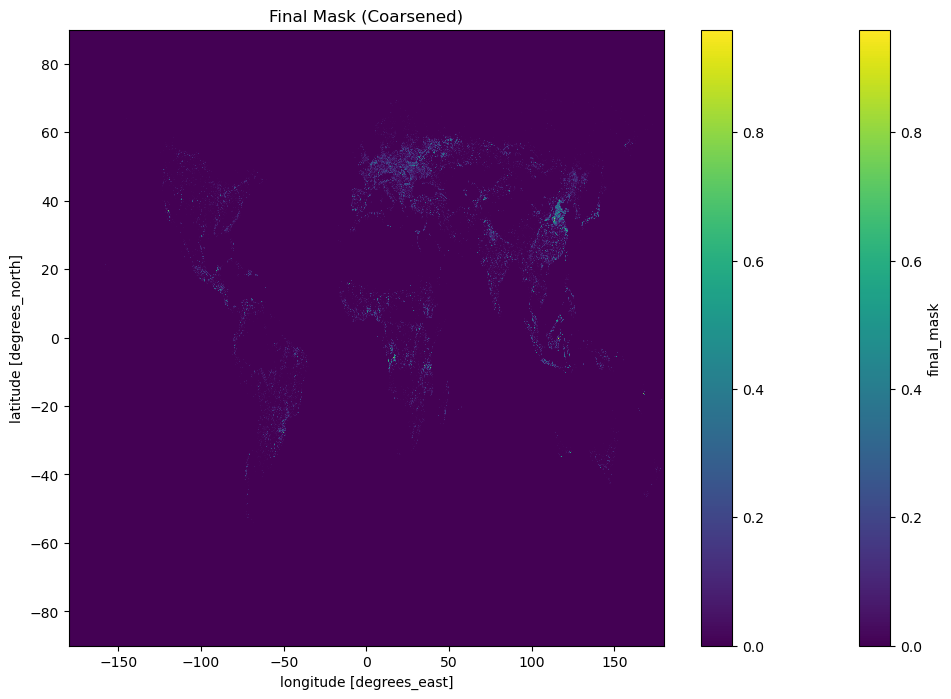

In [12]:
data = xr.open_dataset(r'D:\xarray\test_mask_1km_new.nc')
import matplotlib.pyplot as plt

# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data where final_mask equals 1
# Store the plot object returned by plot() to use with colorbar
plot = data.final_mask.coarsen(lat=10, lon=10).mean().plot(ax=ax)
plt.title('Final Mask (Coarsened)')

# Use the plot object with colorbar
plt.colorbar(plot)


### （2）土地利用重采样为1KM

In [8]:
import numpy as np
import xarray as xr
import os

# === 参数 ===
input_path = r'output/recalss_lccs.nc'
output_path = r'D:/xarray/reclass_lccs_1km.nc'
factor = 3  # 10 arcsec (0.0027°) → 1km (~0.0083°), 大约3倍

# === 打开数据 ===
ds = xr.open_dataset(input_path, chunks={})  # 不指定 lat/lon chunk，避免边界错位警告

# === 自动识别 chunk 大小 ===
print(f"原始分辨率：lat step={ds.lat[1] - ds.lat[0]:.6f}, lon step={ds.lon[1] - ds.lon[0]:.6f}")
ds = ds.chunk({'time': 1})  # 时间分块，lat/lon 后面聚合

# === 使用 coarsen 进行空间降采样 ===
# mode: 使用最近邻方式合并（适合分类数据），也可换 mean/max/min 等
reduced_ds = ds.coarsen(lat=factor, lon=factor, boundary='trim').reduce(np.nanmean)
reduced_ds = reduced_ds.round()  # 由于是类别型，取平均后四舍五入回整数
reduced_ds = reduced_ds.astype('uint8')  # 假设你的 lccs_class 分类值可落入 0~255

# === 设置压缩编码（重要） ===
encoding = {
    var: {
        'zlib': True,
        'complevel': 9,
        'shuffle': True,
        'dtype': 'uint8',
        '_FillValue': 255,
        'chunksizes': (1, 500, 500)
    } for var in reduced_ds.data_vars
}

# === 写入 NetCDF 文件 ===
reduced_ds.to_netcdf(output_path, encoding=encoding, compute=True)
print(f"✅ 重采样完成并保存为：{output_path}")


原始分辨率：lat step=-0.002778, lon step=0.002778
✅ 重采样完成并保存为：D:/xarray/reclass_lccs_1km.nc


### （3）撂荒计算执行

1. 

In [2]:
import os
import gc
import re
import numpy as np
import xarray as xr
from dask.distributed import Client, as_completed
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# === 1. 启动 Dask 分布式客户端 ===
client = Client()  
print(f"Dask Dashboard: {client.dashboard_link}")

# === 2. 路径 & 参数设置 ===
input_path = r'D:\xarray\reclass_lccs_1km.nc'
mask_path  = r'D:\xarray\final_mask_1km_new.nc'
out_dir    = r'D:\xarray\abandonment_chunk'
os.makedirs(out_dir, exist_ok=True)

chunk_size_lat = 500
chunk_size_lon = 500

# === 3. 打开并 persist 数据 ===
ds       = xr.open_dataset(input_path, chunks={'time':1})
ds       = client.persist(ds)  # 保持在集群内存
mask_ds  = xr.open_dataset(mask_path)
years    = ds.time.dt.year.values
lat_size = ds.sizes['lat']
lon_size = ds.sizes['lon']

# === 4. 构造有效像元列表 & 分块映射 ===
valid  = (mask_ds['final_mask'] == 1).values
ys, xs = np.where(valid)
pixels = list(zip(ys, xs))

chunk_map = {}
for y, x in pixels:
    ci = y // chunk_size_lat
    cj = x // chunk_size_lon
    key = (ci, cj)
    rel = (y % chunk_size_lat, x % chunk_size_lon, y, x)
    chunk_map.setdefault(key, []).append(rel)

# === 5. 分类 & 撂荒检测函数 ===
def classify_category(v):
    if   v==1:         return '1'
    elif v==7:         return '7'
    elif v in (8,9):   return 'X'
    else:              return '0'

def classify_sequence_current_only(seq):
    # 转为字符串序列
    s = ''.join(classify_category(v) for v in seq)
    if not s.startswith("11"):
        return np.nan,0,0,0
    matches = list(re.finditer(r"1{2,}(0{5,})", s))
    if not matches:
        return np.nan,0,0,0
    m     = matches[-1]
    start = m.start(1)
    dur   = len(m.group(1))
    year0 = years[start+1]
    after = s[m.end():]
    rec   = int('11' in after)      # 至少两年耕地复垦
    built = int('7' in after)
    curr  = int(not(rec or built))
    return year0, dur, rec, curr

# === 6. 主处理函数（Worker 上执行） ===
def process_chunk(key, pixel_list):
    ci, cj = key
    ys, xs = ci*chunk_size_lat, cj*chunk_size_lon
    ye, xe = min(ys+chunk_size_lat, lat_size), min(xs+chunk_size_lon, lon_size)
    sub = ds.isel(lat=slice(ys,ye), lon=slice(xs,xe)).load()
    arr = sub['lccs_class'].values    # (time, h, w)
    t,h,w = arr.shape
    # 预分配
    year0 = np.full((h,w), np.nan, dtype=np.float32)
    dur   = np.full((h,w), np.nan, dtype=np.float32)
    rec   = np.zeros((h,w), dtype=np.uint8)
    curr  = np.zeros((h,w), dtype=np.uint8)
    for ly, lx, _, _ in pixel_list:
        y0,d,r,c = classify_sequence_current_only(arr[:,ly,lx])
        if not np.isnan(y0):
            year0[ly,lx] = y0
            dur[ly,lx]   = d
            rec[ly,lx]   = r
            curr[ly,lx]  = c
    # 构造 Dataset 并写出
    out = xr.Dataset(
        data_vars={
            'abandonment_year':      (('lat','lon'), year0),
            'abandonment_duration':  (('lat','lon'), dur),
            'recultivation':         (('lat','lon'), rec),
            'current_abandonment':   (('lat','lon'), curr)
        },
        coords={'lat':sub.lat, 'lon':sub.lon}
    )
    encoding = {
        'abandonment_year':     {'zlib':True,'complevel':9,'dtype':'float32','_FillValue':np.nan},
        'abandonment_duration': {'zlib':True,'complevel':9,'dtype':'float32','_FillValue':np.nan},
        'recultivation':        {'zlib':True,'complevel':9,'dtype':'uint8','_FillValue':0},
        'current_abandonment':  {'zlib':True,'complevel':9,'dtype':'uint8','_FillValue':0},
    }
    path = os.path.join(out_dir, f'chunk_{ci}_{cj}.nc')
    out.to_netcdf(path, encoding=encoding)
    # 清理
    del sub, out, arr
    gc.collect()
    return path

# === 7. 分批提交并限流执行 ===
batch = 50
keys = list(chunk_map.items())
futures = []
for i in range(0, len(keys), batch):
    block = keys[i:i+batch]
    # 提交 batch
    for key,pix in block:
        futures.append(client.submit(process_chunk, key, pix))
    # 等待 batch 完成并回收
    for fut in as_completed(futures[-len(block):]):
        _ = fut.result()
        del fut
    client.run(gc.collect)

print("✅ 所有块已处理并保存。")

# 若需要监控进度，可使用 Dask Dashboard，无需额外 ProgressBar。  


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.6.3.
Continuing without the dashboard.
  warnings.warn(


Dask Dashboard: http://127.0.0.1:8787/status


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distributed\worker.py:3031: UserWarning: Large object of size 0.99 MiB detected in task graph: 
  ((8, 48), [(0, 132, 4000, 24132), (0, 133, 4000, 2 ...  4499, 24499)])
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
2025-05-06 19:33:47,108 - distributed.scheduler - ERROR - Couldn't gather keys {'process_chunk-01367cf2ffa6ec80c5bba72a8a982d07': ['tcp://127.0.0.1:11065']} state: ['memory'] workers: ['tcp://127.0.0.1:11065']
NoneType: None
2025-05-06 19:33:58,043 - distributed.scheduler - ERROR - Shut down workers that don't have promised key: ['tcp://127.0.0.1:11065'], process_chunk-01367cf2ffa6ec80c5bba72a8a982d07
NoneType: None
2025-05-06 19:33:58,048 - distributed.scheduler - WAR

✅ 所有块已处理并保存。


In [3]:
import os
import glob

import xarray as xr
import matplotlib.pyplot as plt

# 1. 指定输出目录
output_dir = r'D:\xarray\abandonment_chunk'

# 2. 找到所有块文件
nc_files = sorted(glob.glob(os.path.join(output_dir, 'chunk_*.nc')))
print(f"Found {len(nc_files)} files")

# 3. 打开多文件为一个 Dataset（按坐标合并）
ds = xr.open_mfdataset(
    nc_files,
    combine='by_coords',
    parallel=True  # 如果已配置 Dask 分布式，可加速合并
)

# 4. 选择要绘制的变量
var = 'current_abandonment'  # 或 'abandonment_year','recultivation' 等

# 5. 空间降采样：每 4×4 网格取一个值（粗化）
#    你可以根据需要调整 factor
factor = 30
ds_coarse = ds[var].coarsen(lat=factor, lon=factor, boundary='trim').max()

# 6. 绘图
plt.figure(figsize=(10, 6))
ds_coarse.plot(
    cmap='viridis',  # 0 和 1 之间
    vmin=0, vmax=1,
    cbar_kwargs={'label': var}
)
plt.title(f"Coarse map of {var}")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


Found 974 files


2025-05-06 22:34:06,677 - distributed.nanny - WARNING - Restarting worker
2025-05-06 23:50:19,024 - distributed.scheduler - ERROR - Couldn't gather keys {'open_dataset-23423136-6ea1-443c-a247-06f7ab0c8fdb': [], 'getattr-54e5afea-c41b-44a3-96d4-b89601c9a26e': [], 'getattr-7b50ddb2-3f9f-4ca0-b0a9-a6385baf4f32': [], 'getattr-cf85c8c2-cb55-41cd-949d-afb28a7b04dc': [], 'open_dataset-1cb138ad-d253-4890-b4bb-3d0e097ce463': [], 'open_dataset-23648ae2-76af-4ea7-ba23-93a8ae4a84c6': [], 'getattr-d5c02506-25df-46ab-b0c3-2bd7da7c07d4': [], 'open_dataset-238429c2-df22-4ca0-8d1e-1efb1d3225cd': []} state: ['processing', 'waiting', 'waiting', 'waiting', 'processing', 'processing', 'waiting', 'processing'] workers: []
NoneType: None
2025-05-06 23:50:19,093 - distributed.scheduler - ERROR - Shut down workers that don't have promised key: [], open_dataset-23423136-6ea1-443c-a247-06f7ab0c8fdb
NoneType: None
2025-05-06 23:50:19,095 - distributed.scheduler - ERROR - Shut down workers that don't have promised

2025-05-06 23:50:19,124 - distributed.client - WARNING - Couldn't gather 8 keys, rescheduling {'open_dataset-23423136-6ea1-443c-a247-06f7ab0c8fdb': (), 'getattr-54e5afea-c41b-44a3-96d4-b89601c9a26e': (), 'getattr-7b50ddb2-3f9f-4ca0-b0a9-a6385baf4f32': (), 'getattr-cf85c8c2-cb55-41cd-949d-afb28a7b04dc': (), 'open_dataset-1cb138ad-d253-4890-b4bb-3d0e097ce463': (), 'open_dataset-23648ae2-76af-4ea7-ba23-93a8ae4a84c6': (), 'getattr-d5c02506-25df-46ab-b0c3-2bd7da7c07d4': (), 'open_dataset-238429c2-df22-4ca0-8d1e-1efb1d3225cd': ()}


KeyboardInterrupt: 

### （4）结果检查

## 2、栅格TIFF数据预处理



### （1）创建标准栅格
处理流程：以tif_path中的有效值为参考，标记全球陆域栅格，1是陆域。

输入：r'D:\Photovoltaic_data\Global_population_density_2020_30_sec.tif'
输出：r'D:\xarray\population_density_simple.nc'

其中，输出的NC格式里，land_mask是布尔类型，1代表陆域、0代表水体（大部分是不需要的海洋、以及部分内陆湖泊）

In [7]:
import os
import gc
import numpy as np
import xarray as xr
import rioxarray

# —— 1. 路径设置 ——
tif_path = r'D:\Photovoltaic_data\Global_population_density_2020_30_sec.tif'
nc_path  = r'D:\xarray\population_density_simple.nc'

os.makedirs(os.path.dirname(nc_path), exist_ok=True)

# —— 2. 读取 GeoTIFF 为 DataArray ——
da = rioxarray.open_rasterio(tif_path, masked=True)
# 如果有带 band 维度则 squeeze
if 'band' in da.dims:
    da = da.squeeze('band', drop=True)

# 重命名坐标一致为 lat/lon
if 'x' in da.dims and 'y' in da.dims:
    da = da.rename({'x': 'lon', 'y': 'lat'})

da.name = 'pop_density'
da.attrs['units'] = 'persons_per_30arcsec'

# —— 3. 构建陆域掩膜 ——
land_mask = da.notnull().astype(bool)
land_mask.name = 'land_mask'
land_mask.attrs['description'] = 'True where population density is valid'

# —— 4. 打包为 Dataset ——
ds = xr.Dataset(
    {
        'pop_density_2020': da,
        'land_mask':   land_mask
    },
    coords={'lat': da['lat'], 'lon': da['lon']},
    attrs={'title': 'Population Density with simple land mask'}
)

# —— 5. 优化编码并保存 ——
encoding = {
    'pop_density_2020': {
        'dtype': 'float32', 'zlib': True, 'complevel': 5, '_FillValue': np.nan
    },
    'land_mask': {
        'dtype': 'bool', 'zlib': True, 'complevel': 5
    }
}
ds.to_netcdf(nc_path, encoding=encoding)

# —— 6. 清理内存 ——
del ds, da, land_mask
gc.collect()

print(f"✅ 已保存简单 NetCDF：{nc_path}")


✅ 已保存简单 NetCDF：D:\xarray\population_density_simple.nc


检测下输出栅格。

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

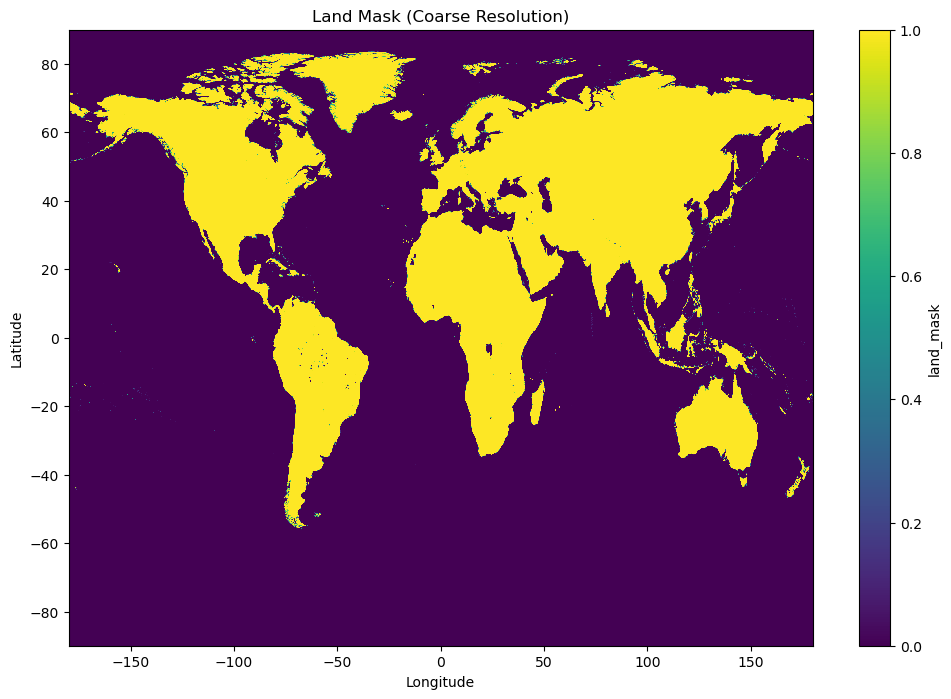

In [3]:
import xarray as xr
import numpy as np
# Load the dataset
nc_path = r'D:\xarray\population_density_simple.nc'
ds = xr.open_dataset(nc_path)

# Create a coarsened version using coarsen method
# coarsen requires reduction functions like mean, max, etc.
mask = ds.coarsen(lat=10, lon=10, boundary='trim').mean()

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Plot the land mask with coarse resolution for faster rendering
plt.figure(figsize=(12, 8))
mask.land_mask.plot(cmap='viridis')
plt.title('Land Mask (Coarse Resolution)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Land (True) / Ocean (False)')
plt.tight_layout()
plt.show()

# Display the coarsened dataset
mask

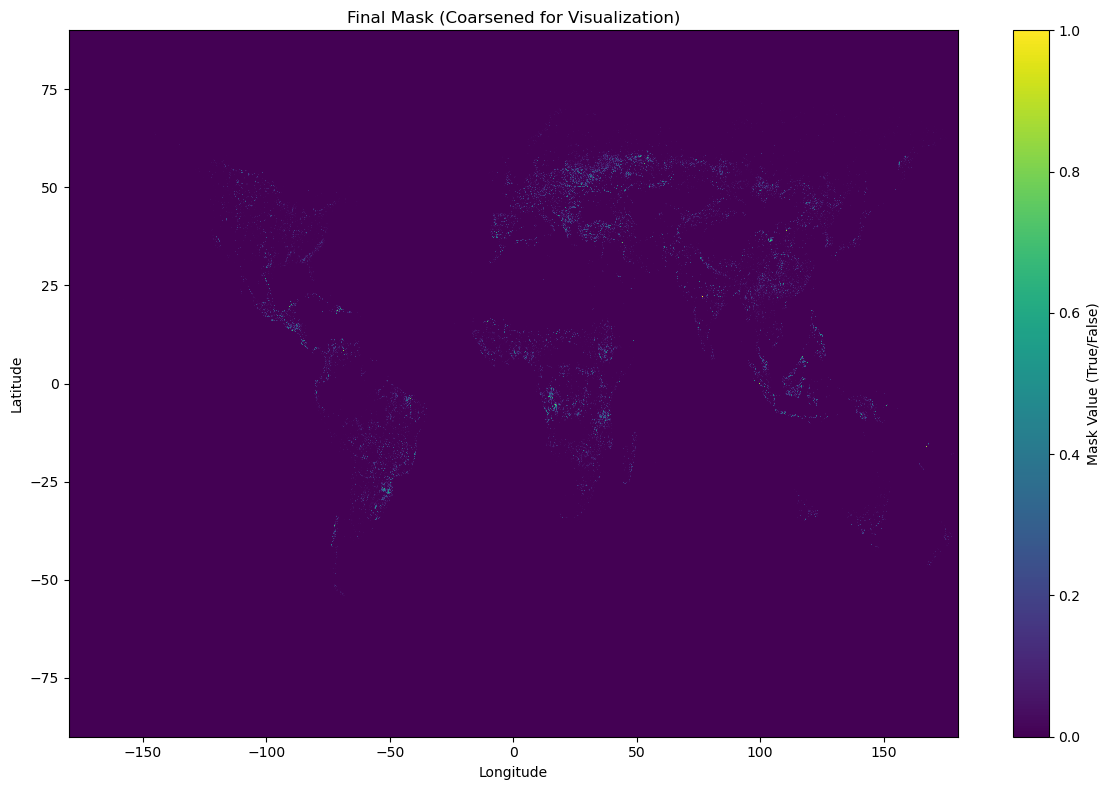

Valid (True) pixels: 13,339,476
Total pixels: 8,398,080,000
Valid percentage: 0.16%


<xarray.Dataset> Size: 8GB
Dimensions:     (lat: 64800, lon: 129600)
Coordinates:
  * lat         (lat) float64 518kB 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon         (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    final_mask  (lat, lon) bool 8GB False False False ... False False False

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Open the dataset
mask_ds = xr.open_dataset(r'output\final_mask.nc')

# Create a coarsened version for plotting to avoid memory error
coarse_mask = mask_ds.coarsen(lat=20, lon=20, boundary='trim').mean()

# Plot the coarsened mask
plt.figure(figsize=(12, 8))
im = plt.pcolormesh(coarse_mask.lon, coarse_mask.lat, coarse_mask.final_mask, cmap='viridis')
plt.colorbar(im, label='Mask Value (True/False)')
plt.title('Final Mask (Coarsened for Visualization)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


